## Entrenamiento de modelos para tipos de ataque informático
Aarón Dali López Fortich (T00068394) -
Jorge Andrés Herrera Monsalve (T00068111)


## Directorio 

In [1]:
import os
import sys
PATH = os.getcwd()
DIR_DATA = PATH + '{0}data{0}'.format(os.sep)
sys.path.append(PATH) if PATH not in list(sys.path) else None
DIR_DATA

'c:\\Users\\usuario\\Documents\\AI_models\\data\\'

## Librerías 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report


from pycaret.classification import *

# ML Al
from sklearn.model_selection import RandomizedSearchCV,RepeatedStratifiedKFold, ShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
# File name
filename = DIR_DATA + 'test_data.csv'
filename2 = DIR_DATA + 'train_data.csv'
print(filename)
print(filename2)

c:\Users\usuario\Documents\AI_models\data\test_data.csv
c:\Users\usuario\Documents\AI_models\data\train_data.csv


## Contenido de los datos 

A continuación se describen las características del conjunto de datos.

Port Numbers (id.orig_p, id.resp_p): Estas características de tipo enteros indiquen los puertos de origen y destino en la comunicación de red, proporcionando información sobre los servicios que se están utilizando.

Protocol (proto): Característica categórica que especifica el protocolo de comunicación, como TCP, UDP, ICMP, etc.

Service (service): Indica el servicio de la capa de aplicación o el protocolo en uso (como HTTP, FTP, DNS), y puede estar mal etiquetado como continuo si se pretende que sea categórico.

Flow Duration (flow_duration): Característica continua que representa el tiempo que ha durado un flujo, normalmente medido en segundos o milisegundos.

Packet Counts (fwd_pkts_tot, bwd_pkts_tot): Características enteras que cuentan el número total de paquetes enviados en la dirección de avance o retroceso.

Data Packet Counts (fwd_data_pkts_tot, bwd_data_pkts_tot): Similar al recuento de paquetes, pero con la posibilidad de excluir determinados tipos de paquetes, centrándose en los que contienen carga útil de datos.

Packets Per Second (fwd_pkts_per_sec, bwd_pkts_per_sec, flow_pkts_per_sec): Características continuas que representan la velocidad de transmisión de paquetes en cualquier dirección o para todo el flujo.

Payload Features (fwd_pkts_payload., bwd_pkts_payload., flow_pkts_payload.*): Estas características continuas podrían incluir estadísticas sobre el tamaño de los datos de carga útil en paquetes, como mínimo, máximo, total, media y desviación estándar.

Inter-Arrival Times (fwd_iat., bwd_iat., flow_iat.*): Estas características continuas probablemente capturan el tiempo entre paquetes en un flujo, proporcionando información sobre el tiempo y potencialmente la ráfaga de tráfico.

Flags (flow_FIN_flag_count, flow_SYN_flag_count, etc.): Recuentos enteros de varios indicadores TCP dentro de un flujo, importantes para comprender la naturaleza del establecimiento, gestión y finalización de la sesión.

Bytes Per Second (payload_bytes_per_second): Característica continua que podría representar la velocidad a la que se transmiten los datos de carga útil en el flujo.

Subflow Features (fwd_subflow_pkts, bwd_subflow_pkts, etc.): Éstas podrían referirse a estadísticas sobre subflujos, que son secuencias más pequeñas de paquetes dentro del flujo principal, de nuevo medidas en métricas continuas como bytes y paquetes.

Bulk Features (fwd_bulk_bytes, bwd_bulk_bytes, etc.): Características continuas que pueden referirse a la transmisión de grandes cantidades de datos en un flujo, a menudo utilizadas para detectar la exfiltración de datos o las transferencias de archivos de gran tamaño.

Active/Idle Times (active.min, active.max, etc.): Funciones continuas que capturan los periodos activos y ociosos dentro de un flujo, lo que puede indicar los patrones de comportamiento de la comunicación.

Window Size (fwd_init_window_size, bwd_init_window_size, fwd_last_window_size): Características enteras que podrían estar relacionadas con el tamaño de las ventanas TCP, importantes para el control de flujo y la gestión de la congestión en las redes.

Attack Type (Attack_type): Característica categórica del objetivo que probablemente indica el tipo de ataque o comportamiento normal, utilizada para la clasificación en un IDS.

## Lectura y análisis de los datos 


In [4]:
train_data = pd.read_csv(filename)
test_data = pd.read_csv(filename2)

In [5]:
train_data.head()

,id,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
0,7984,10826,21,tcp,-,0.000005,1,1,1,0,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,64,0,64,DOS_SYN_Hping
1,20470,23313,21,tcp,-,0.000001,1,1,1,0,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,64,0,64,DOS_SYN_Hping
2,14078,16920,21,tcp,-,0.000004,1,1,1,0,...,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,64,0,64,DOS_SYN_Hping
3,3651,50229,1883,tcp,mqtt,62.130249,10,6,3,4,...,0.0,5.981429e+07,5.981429e+07,5.981429e+07,5.981429e+07,0.0,64240,26847,502,MQTT_Publish
4,2240,51915,1883,tcp,mqtt,14.941909,9,5,3,3,...,0.0,1.284753e+07,1.284753e+07,1.284753e+07,1.284753e+07,0.0,64240,26847,502,MQTT_Publish


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24624 entries, 0 to 24623
Data columns (total 85 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        24624 non-null  int64  
 1   id.orig_p                 24624 non-null  int64  
 2   id.resp_p                 24624 non-null  int64  
 3   proto                     24624 non-null  object 
 4   service                   24624 non-null  object 
 5   flow_duration             24624 non-null  float64
 6   fwd_pkts_tot              24624 non-null  int64  
 7   bwd_pkts_tot              24624 non-null  int64  
 8   fwd_data_pkts_tot         24624 non-null  int64  
 9   bwd_data_pkts_tot         24624 non-null  int64  
 10  fwd_pkts_per_sec          24624 non-null  float64
 11  bwd_pkts_per_sec          24624 non-null  float64
 12  flow_pkts_per_sec         24624 non-null  float64
 13  down_up_ratio             24624 non-null  float64
 14  fwd_he

In [7]:
train_data.describe()

,id,id.orig_p,id.resp_p,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
count,24624.000000,24624.000000,24624.000000,24624.000000,24624.000000,24624.000000,24624.000000,24624.000000,2.462400e+04,2.462400e+04,...,2.462400e+04,2.462400e+04,2.462400e+04,2.462400e+04,2.462400e+04,2.462400e+04,2.462400e+04,24624.000000,24624.000000,24624.000000
mean,36979.025869,34599.856441,992.887955,3.236076,2.201592,1.826673,1.453866,0.739157,3.506855e+05,3.506426e+05,...,1.450155e+05,1.791138e+04,1.669190e+06,1.750799e+06,2.908292e+06,1.715319e+06,4.566996e+04,6161.432302,2764.786103,706.259828
std,30522.124455,19069.140498,5127.657115,71.497076,15.065468,12.040878,13.705952,11.284515,3.699006e+05,3.699398e+05,...,5.797878e+05,2.531490e+05,9.014839e+06,9.471426e+06,5.457715e+07,9.214317e+06,1.244195e+06,18775.917284,10021.645224,6083.516718
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,6042.750000,17675.750000,21.000000,0.000001,1.000000,1.000000,1.000000,0.000000,7.355639e+01,7.152313e+01,...,9.536740e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,64.000000,0.000000,64.000000
50%,32833.500000,37191.000000,21.000000,0.000004,1.000000,1.000000,1.000000,0.000000,2.467238e+05,2.467238e+05,...,4.053116e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,64.000000,0.000000,64.000000
75%,64058.250000,50866.750000,21.000000,0.000005,1.000000,1.000000,1.000000,0.000000,5.242880e+05,5.242880e+05,...,5.006790e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,64.000000,0.000000,64.000000
max,94655.000000,65533.000000,65389.000000,9433.886888,1887.000000,1263.000000,1887.000000,1263.000000,1.048576e+06,1.048576e+06,...,1.595862e+07,1.154480e+07,3.000000e+08,3.000000e+08,6.488665e+09,3.000000e+08,1.208029e+08,65535.000000,65535.000000,65535.000000


## Preprocesamiento: encontrando los valores nulos

In [8]:
# Análisis de datos nulos
print("Conteno de valores nulos en el dataset de entrenamiento")
print(train_data.isnull().sum())
print("\nConteno de valores nulos en el dataset de test")
print(test_data.isnull().sum())

#Al darnos cuenta que algunos campos el valor nulo es reemplazado por '-' entonces se procede a tratarlos
print ("\nConteo de valores nulos posterior al tratamiento de carácter '-'")
train_data = train_data.replace('-', np.nan)
print(train_data.isnull().sum())
test_data = test_data.replace('-', np.nan)
print(test_data.isnull().sum())



Conteno de valores nulos en el dataset de entrenamiento
id                      0
id.orig_p               0
id.resp_p               0
proto                   0
service                 0
                       ..
idle.std                0
fwd_init_window_size    0
bwd_init_window_size    0
fwd_last_window_size    0
Attack_type             0
Length: 85, dtype: int64

Conteno de valores nulos en el dataset de test
id                      0
id.orig_p               0
id.resp_p               0
proto                   0
service                 0
                       ..
idle.std                0
fwd_init_window_size    0
bwd_init_window_size    0
fwd_last_window_size    0
Attack_type             0
Length: 85, dtype: int64

Conteo de valores nulos posterior al tratamiento de carácter '-'
id                          0
id.orig_p                   0
id.resp_p                   0
proto                       0
service                 20570
                        ...  
idle.std                    

In [9]:
train_data['service'] = train_data['service'].fillna('unknown')
test_data['service'] = test_data['service'].fillna('unknown')

#Al asignar un valor "unknown" a los valores nulos de la columna service, se puede observar que el número de valores nulos en esta columna es cero
print("\nConteo de valores nulos posterior al tratamiento de carácter '-' y asignación de valor 'unknown'")
print(train_data.isnull().sum())
print(test_data.isnull().sum())


Conteo de valores nulos posterior al tratamiento de carácter '-' y asignación de valor 'unknown'
id                      0
id.orig_p               0
id.resp_p               0
proto                   0
service                 0
                       ..
idle.std                0
fwd_init_window_size    0
bwd_init_window_size    0
fwd_last_window_size    0
Attack_type             0
Length: 85, dtype: int64
id                      0
id.orig_p               0
id.resp_p               0
proto                   0
service                 0
                       ..
idle.std                0
fwd_init_window_size    0
bwd_init_window_size    0
fwd_last_window_size    0
Attack_type             0
Length: 85, dtype: int64


## Correlación entre las features numéricas

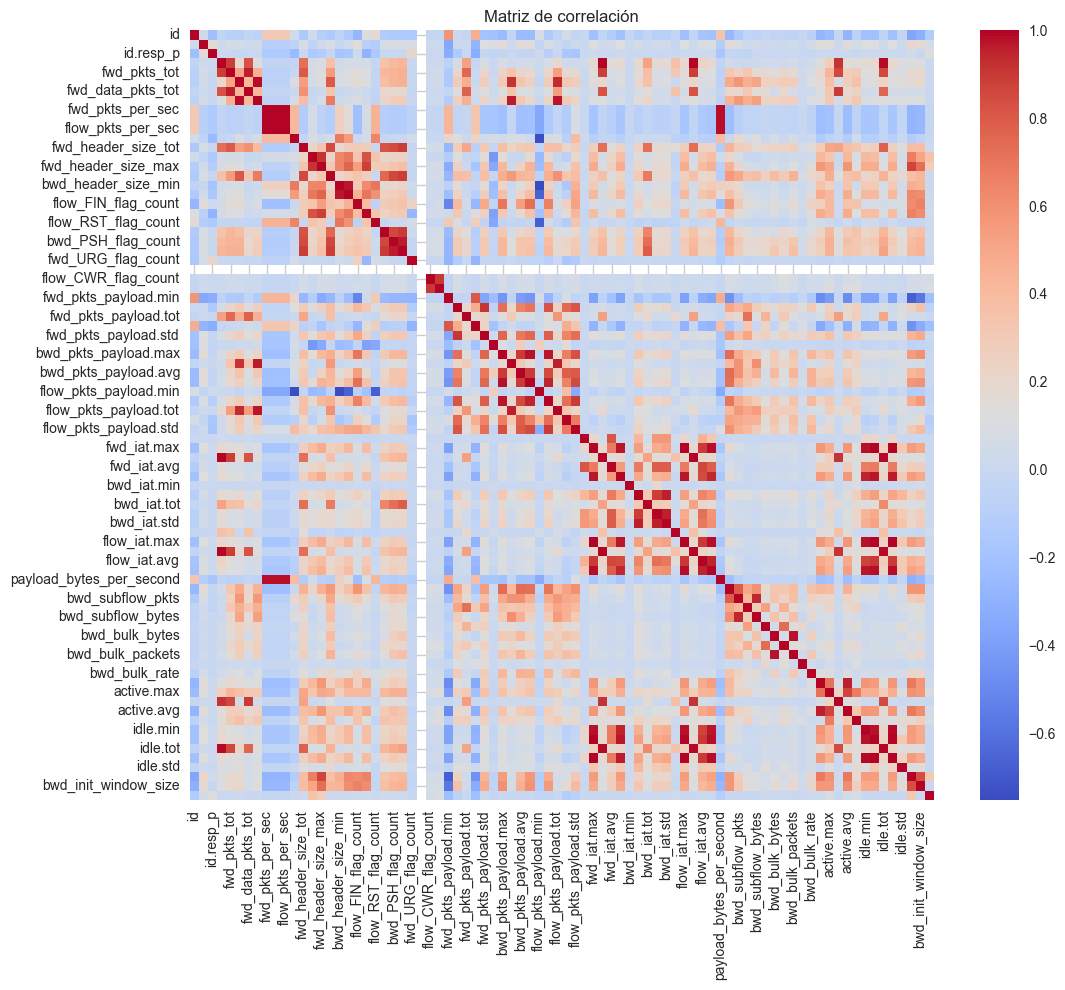

In [10]:
numeric_cols = train_data.select_dtypes(include='number').columns
corr = train_data[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

> Esta gráfica se usa para mirar la correlación entre las features que vienen en el dataset, recordando que solo se emplea para aquellas que son de tipos numéricos, esta correlación nos estará indicando la relación entre las diversas variables y el sentido de su relación (bien sea relación directa o inversa)

## Transformar features categóricas

In [11]:
le = LabelEncoder()
y_train = le.fit_transform(train_data["Attack_type"])
y_test = le.transform(test_data["Attack_type"])  # usar transform() directamente si ya fue entrenado


# Eliminar la columna de etiqueta del dataframe de entrada
X_train = train_data.drop("Attack_type", axis=1)
X_test = test_data.drop("Attack_type", axis=1)

# Ver el mapeo original
list(zip(le.classes_, le.transform(le.classes_)))


[('ARP_poisioning', 0),
 ('DDOS_Slowloris', 1),
 ('DOS_SYN_Hping', 2),
 ('MQTT_Publish', 3),
 ('Metasploit_Brute_Force_SSH', 4),
 ('NMAP_FIN_SCAN', 5),
 ('NMAP_OS_DETECTION', 6),
 ('NMAP_TCP_scan', 7),
 ('NMAP_UDP_SCAN', 8),
 ('NMAP_XMAS_TREE_SCAN', 9),
 ('Thing_Speak', 10),
 ('Wipro_bulb', 11)]

Empleo de función get_dummies() para transformar features categóricas diferentes a valores objetivo

In [12]:
X_encoded = pd.get_dummies(X_train, drop_first=True)

# Convertir a array NumPy para alimentar el modelo
X_array = X_encoded.values


X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Alinear columnas entre train y test para que tengan las mismas features
X_encoded, X_test_encoded = X_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Convertir a arrays
X_train = X_encoded.values
X_test = X_test_encoded.values


## Visualización de la distribución original de las categorías en la variable objetivo de clasificación

Mapeo de clases:
0: ARP_poisioning
1: DDOS_Slowloris
2: DOS_SYN_Hping
3: MQTT_Publish
4: Metasploit_Brute_Force_SSH
5: NMAP_FIN_SCAN
6: NMAP_OS_DETECTION
7: NMAP_TCP_scan
8: NMAP_UDP_SCAN
9: NMAP_XMAS_TREE_SCAN
10: Thing_Speak
11: Wipro_bulb

Distribución de clases en y_train:
Clase 0 (ARP_poisioning): 1488 muestras
Clase 1 (DDOS_Slowloris): 103 muestras
Clase 2 (DOS_SYN_Hping): 18925 muestras
Clase 3 (MQTT_Publish): 861 muestras
Clase 4 (Metasploit_Brute_Force_SSH): 12 muestras
Clase 5 (NMAP_FIN_SCAN): 11 muestras
Clase 6 (NMAP_OS_DETECTION): 390 muestras
Clase 7 (NMAP_TCP_scan): 178 muestras
Clase 8 (NMAP_UDP_SCAN): 519 muestras
Clase 9 (NMAP_XMAS_TREE_SCAN): 411 muestras
Clase 10 (Thing_Speak): 1672 muestras
Clase 11 (Wipro_bulb): 54 muestras


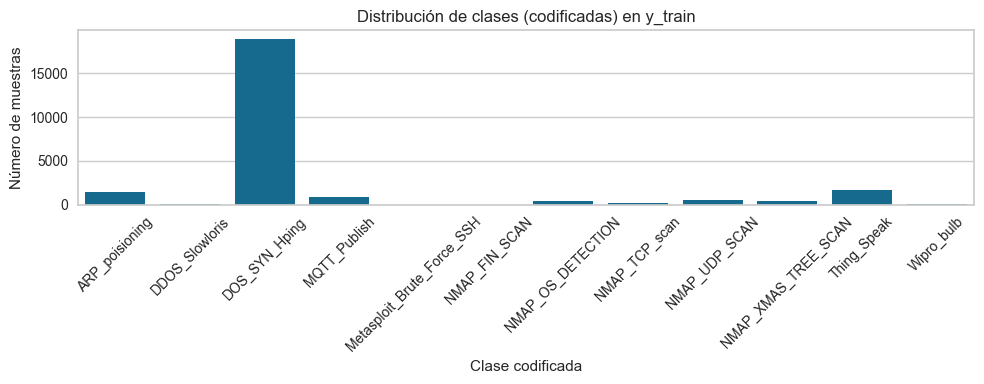

In [13]:


# Mostrar mapeo clase ↔ número
print("Mapeo de clases:")
for label, index in zip(le.classes_, range(len(le.classes_))):
    print(f"{index}: {label}")

# Contar frecuencia de clases en y_train
unique, counts = np.unique(y_train, return_counts=True)

# Imprimir conteo
print("\nDistribución de clases en y_train:")
for label, count in zip(unique, counts):
    print(f"Clase {label} ({le.inverse_transform([label])[0]}): {count} muestras")

# Visualización con Seaborn
plt.figure(figsize=(10, 4))
sns.countplot(x=y_train)
plt.title("Distribución de clases (codificadas) en y_train")
plt.xlabel("Clase codificada")
plt.ylabel("Número de muestras")
plt.xticks(ticks=range(len(unique)), labels=le.inverse_transform(unique), rotation=45)
plt.tight_layout()
plt.show()


> Como se puede notar en el gráfico superior, existe un desbalanceo entre las clases objetivo de nuestro modelo (representando cada una de ellas un tipo de ataque informático), esto se puede solucionar igualando el número de muestras de cada clase por medio de SMOTE


## Empleo de la técnica de SMOTE para el balanceo de las clases

Antes del balanceo: Counter({2: 18925, 10: 1672, 0: 1488, 3: 861, 8: 519, 9: 411, 6: 390, 7: 178, 1: 103, 11: 54, 4: 12, 5: 11})
Después del balanceo: Counter({2: 18925, 3: 18925, 9: 18925, 0: 18925, 10: 18925, 8: 18925, 6: 18925, 1: 18925, 7: 18925, 4: 18925, 11: 18925, 5: 18925})

Distribución balanceada por clase:
Clase 2 (DOS_SYN_Hping): 18925 muestras
Clase 3 (MQTT_Publish): 18925 muestras
Clase 9 (NMAP_XMAS_TREE_SCAN): 18925 muestras
Clase 0 (ARP_poisioning): 18925 muestras
Clase 10 (Thing_Speak): 18925 muestras
Clase 8 (NMAP_UDP_SCAN): 18925 muestras
Clase 6 (NMAP_OS_DETECTION): 18925 muestras
Clase 1 (DDOS_Slowloris): 18925 muestras
Clase 7 (NMAP_TCP_scan): 18925 muestras
Clase 4 (Metasploit_Brute_Force_SSH): 18925 muestras
Clase 11 (Wipro_bulb): 18925 muestras
Clase 5 (NMAP_FIN_SCAN): 18925 muestras


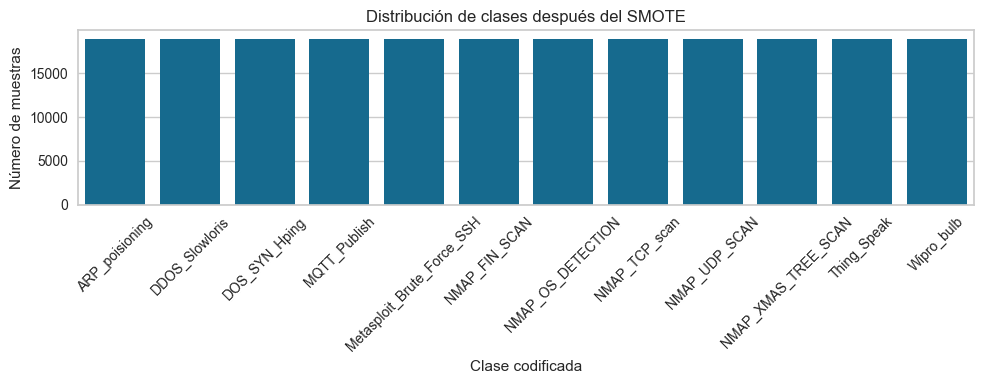

In [14]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Mostrar nuevas dimensiones
print("Antes del balanceo:", Counter(y_train))
print("Después del balanceo:", Counter(y_train_balanced))

# Mostrar mapeo clases con nombres
print("\nDistribución balanceada por clase:")
for label, count in Counter(y_train_balanced).items():
    print(f"Clase {label} ({le.inverse_transform([label])[0]}): {count} muestras")

# Visualización
plt.figure(figsize=(10, 4))
sns.countplot(x=y_train_balanced)
plt.title("Distribución de clases después del SMOTE")
plt.xlabel("Clase codificada")
plt.ylabel("Número de muestras")
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_, rotation=45)
plt.tight_layout()
plt.show()

> Nota: en este caso podemos observar que ahora todas las clases poseen igual número de muestras, esto se realizó con el fin de que el modelo no tenga sesgos a la hora de realizar predicciones



## Normalización

In [15]:
# Aplicar normalización (StandardScaler), dado que empleamos modelos como svm y regresión logística
# que son sensibles a la escala de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)


In [16]:
k_fold = ShuffleSplit(n_splits=10, test_size=0.30, random_state=42)

In [17]:
# Se crea un nuevo DataFrame para el entrenamiento con las características escaladas y la etiqueta
# Convertir a DataFrame para PyCaret
train_data = pd.DataFrame(X_train_scaled)
train_data['target'] = y_train_balanced

# se inicializa el entorno de PyCaret
clf_setup = setup(
    data=train_data,
    target='target',
    session_id=123,
    train_size=0.7,
)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Multiclass
3,Original data shape,"(227100, 93)"
4,Transformed data shape,"(227100, 93)"
5,Transformed train set shape,"(158970, 93)"
6,Transformed test set shape,"(68130, 93)"
7,Numeric features,92
8,Preprocess,True
9,Imputation type,simple


In [18]:
model = compare_models(fold=10,n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9998,1.0000,0.9998,0.9998,0.9998,0.9998,0.9998,11.4090
et,Extra Trees Classifier,0.9996,1.0000,0.9996,0.9996,0.9996,0.9996,0.9996,3.1180
rf,Random Forest Classifier,0.9994,1.0000,0.9994,0.9994,0.9994,0.9993,0.9993,4.1070
dt,Decision Tree Classifier,0.9993,0.9996,0.9993,0.9993,0.9993,0.9992,0.9992,0.9440
gbc,Gradient Boosting Classifier,0.9991,0.0000,0.9991,0.9991,0.9991,0.9991,0.9991,193.8590
knn,K Neighbors Classifier,0.9986,0.9999,0.9986,0.9986,0.9986,0.9984,0.9984,5.3320
lr,Logistic Regression,0.9890,0.0000,0.9890,0.9892,0.9890,0.9880,0.9881,5.2670
svm,SVM - Linear Kernel,0.9841,0.0000,0.9841,0.9843,0.9841,0.9827,0.9827,0.9130
lda,Linear Discriminant Analysis,0.9528,0.0000,0.9528,0.9542,0.9525,0.9485,0.9487,0.8920
ridge,Ridge Classifier,0.9513,0.0000,0.9513,0.9540,0.9506,0.9469,0.9473,0.2920


> Se muestra en la anterior tabla los diferentes modelos que podemos aplicar, en este caso, se quería verificar las métricas que arroja cada uno para saber cuáles serían los más eficientes para nuestro dataset

## Creación de los modelos

En este caso se tomaran como prueba los modelos de regresión logística, svm y árbol de decisión

In [19]:
model1= create_model('lr')
model2= create_model('svm')
model3= create_model('dt')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9900,0.0000,0.9900,0.9901,0.9900,0.9891,0.9891
1,0.9902,0.0000,0.9902,0.9903,0.9902,0.9893,0.9893
2,0.9892,0.0000,0.9892,0.9894,0.9892,0.9883,0.9883
3,0.9882,0.0000,0.9882,0.9885,0.9882,0.9872,0.9872
4,0.9887,0.0000,0.9887,0.9888,0.9887,0.9877,0.9877
5,0.9891,0.0000,0.9891,0.9893,0.9891,0.9881,0.9881
6,0.9887,0.0000,0.9887,0.9888,0.9887,0.9876,0.9877
7,0.9894,0.0000,0.9894,0.9896,0.9893,0.9884,0.9884
8,0.9882,0.0000,0.9882,0.9883,0.9881,0.9871,0.9871


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9841,0.0000,0.9841,0.9843,0.9841,0.9827,0.9827
1,0.9858,0.0000,0.9858,0.9860,0.9858,0.9846,0.9846
2,0.9851,0.0000,0.9851,0.9853,0.9851,0.9837,0.9838
3,0.9826,0.0000,0.9826,0.9828,0.9826,0.9810,0.9810
4,0.9851,0.0000,0.9851,0.9852,0.9850,0.9837,0.9838
5,0.9837,0.0000,0.9837,0.9839,0.9837,0.9822,0.9823
6,0.9838,0.0000,0.9838,0.9840,0.9837,0.9823,0.9823
7,0.9851,0.0000,0.9851,0.9853,0.9850,0.9837,0.9838
8,0.9836,0.0000,0.9836,0.9839,0.9836,0.9821,0.9821


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9994,0.9997,0.9994,0.9994,0.9994,0.9994,0.9994
1,0.9991,0.9995,0.9991,0.9991,0.9991,0.9990,0.9990
2,0.9989,0.9994,0.9989,0.9989,0.9989,0.9988,0.9988
3,0.9994,0.9997,0.9994,0.9994,0.9994,0.9993,0.9993
4,0.9992,0.9996,0.9992,0.9992,0.9992,0.9991,0.9991
5,0.9994,0.9997,0.9994,0.9994,0.9994,0.9993,0.9993
6,0.9994,0.9997,0.9994,0.9994,0.9994,0.9994,0.9994
7,0.9990,0.9995,0.9990,0.9990,0.9990,0.9989,0.9989
8,0.9996,0.9998,0.9996,0.9996,0.9996,0.9995,0.9995


> Nota: los recuadros superiores que detallan la creación de los modelos van en orden de regresión logística, máquina de soporte de vectores (svm) y decision tree classifier (dt)

In [20]:
# Se muestra el modelo creado
print(model1)
print (model2)
print (model3)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=123, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_

In [21]:
# Desplegamos los hiperparámetros de los modelos
print("\nHiperparámetros del modelo 1 (Regresión Logística):")
print(model1.get_params())
print("\n ")
print("Hiperparámetros del modelo 2 (SVM):")
print(model2.get_params())
print("\n ")
print("Hiperparámetros del modelo 3 (Árbol de Decisión):")
print(model3.get_params())


Hiperparámetros del modelo 1 (Regresión Logística):
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 123, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

 
Hiperparámetros del modelo 2 (SVM):
{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.001, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'l2', 'power_t': 0.5, 'random_state': 123, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

 
Hiperparámetros del modelo 3 (Árbol de Decisión):
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf'

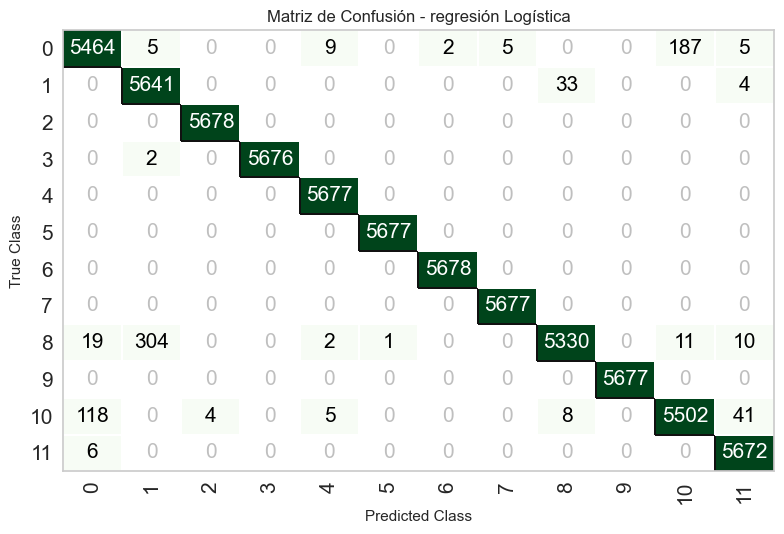

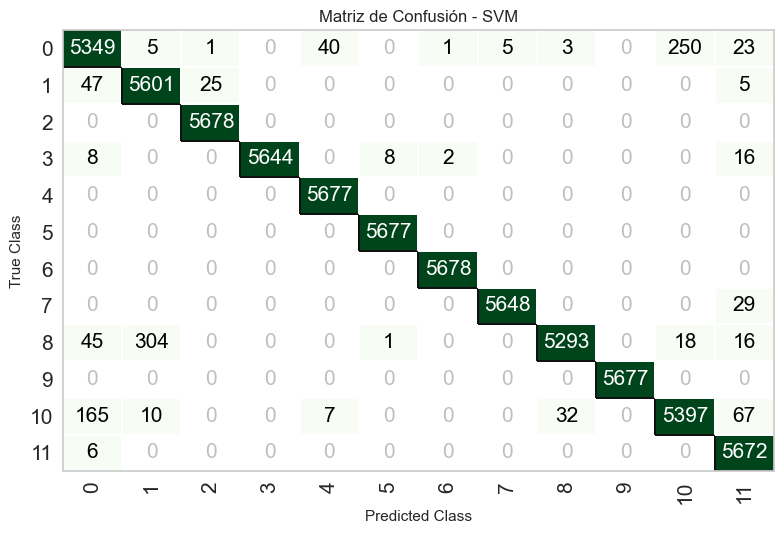

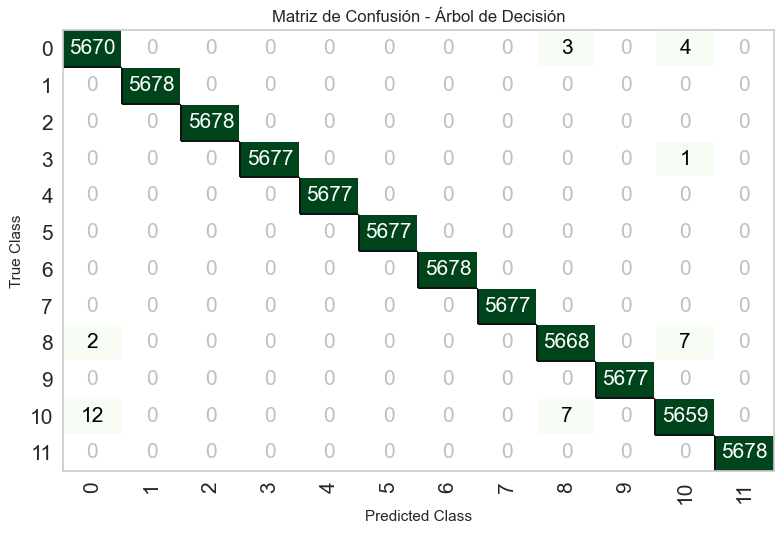

In [22]:
# Se muestran las matrices de confusión de los modelos
plot_model(model1, plot='confusion_matrix', plot_kwargs={'title': 'Matriz de Confusión - regresión Logística'})
plot_model(model2, plot='confusion_matrix', plot_kwargs={'title': 'Matriz de Confusión - SVM'})
plot_model(model3, plot='confusion_matrix', plot_kwargs={'title': 'Matriz de Confusión - Árbol de Decisión'})

>Este gráfico se emplea para definir la matriz de confusión de los modelos evaluados, nos permite saber los valores de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos, es usualmente de interés la diagonal secundaria ya que en esta se establecen los valores verdaderos, tanto positivos como negativos de nuestro modelo.

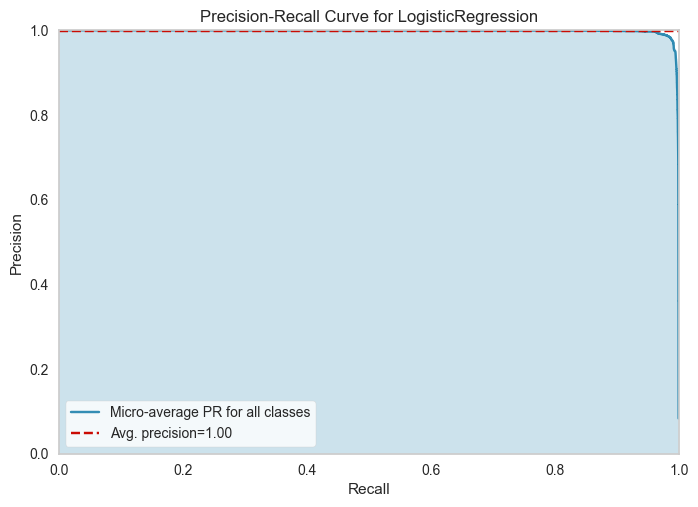

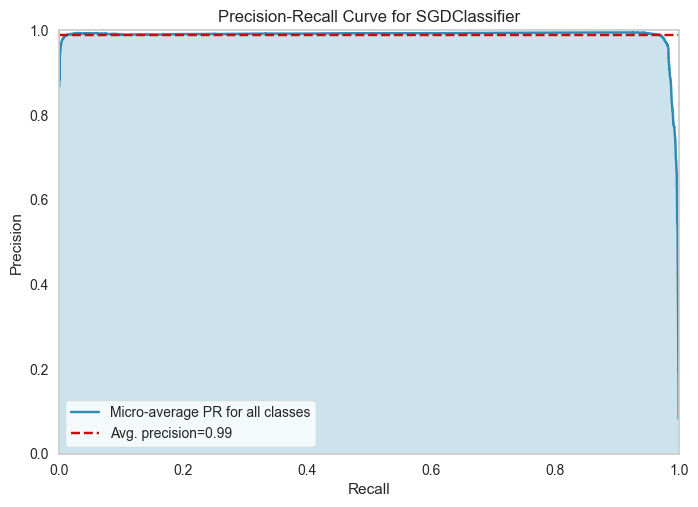

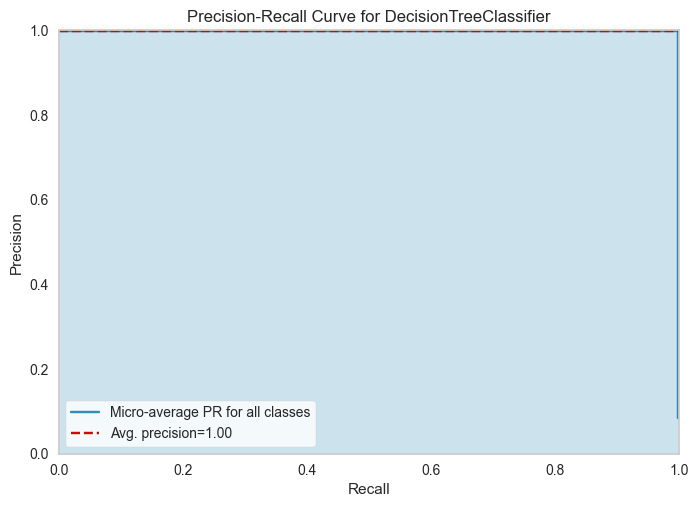

In [23]:
# Se genera el gráfico de la curva precisión-recall para los modelos creados
plot_model(model1, plot='pr')
plot_model(model2, plot='pr')
plot_model(model3, plot='pr')

> Se utilizó esta curva para evaluar el modelo en un escenario con clases desbalanceadas, donde métricas como accuracy fallan. Muestra el trade-off entre precisión (calidad de predicciones positivas) y recall (capacidad de detectar casos positivos), dadas las comparativas entre modelos antes evaluadas era de esperarse que los valores de precisión promedio que arroja por la línea punteada roja fuera bastante alto.


Importancia de características del modelo 1 (Regresión Logística):


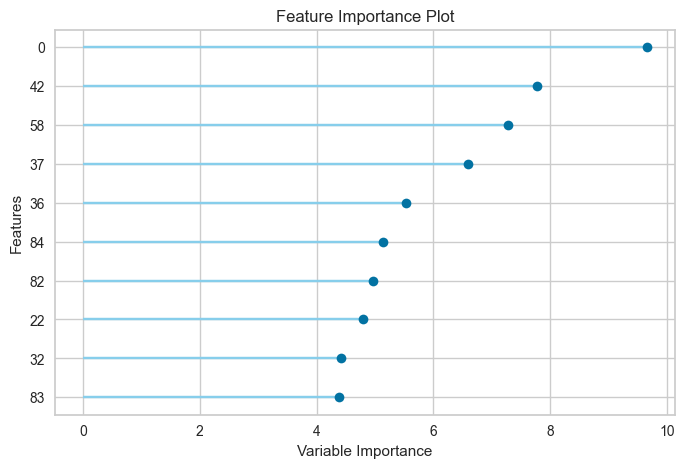


Importancia de características del modelo 2 (SVM):


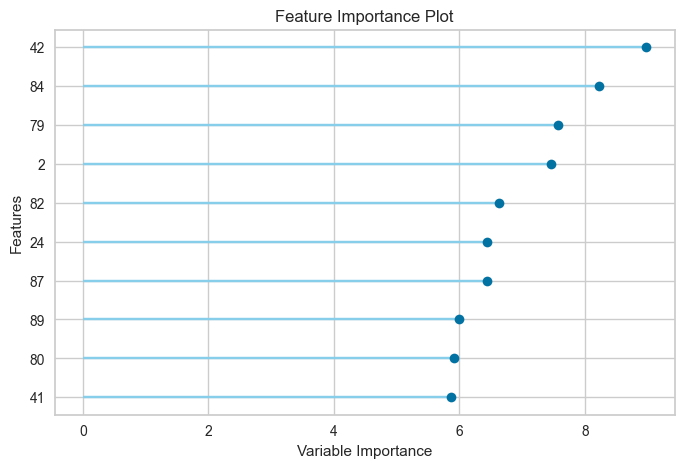


Importancia de características del modelo 3 (Árbol de Decisión):


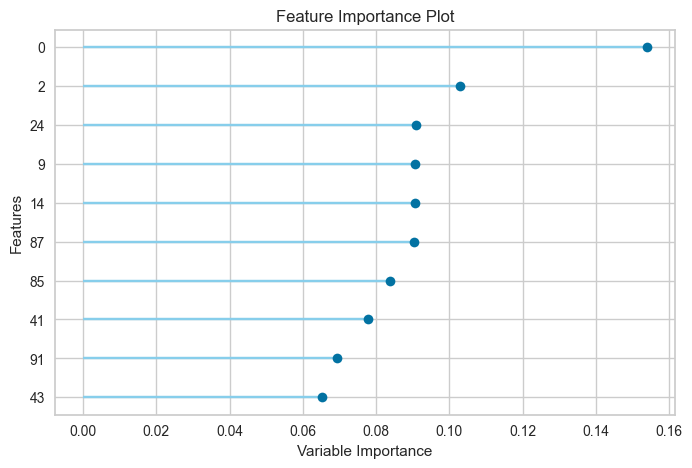

In [24]:
# Generamos un gráfico de importancia de características del modelo entrenado.
print("\nImportancia de características del modelo 1 (Regresión Logística):")
plot_model(model1, plot='feature')
print("\nImportancia de características del modelo 2 (SVM):")
plot_model(model2, plot='feature')
print("\nImportancia de características del modelo 3 (Árbol de Decisión):")
plot_model(model3, plot='feature')

> En este caso se muestra un gráfico de la relevancia que tienen ciertas características en nuestro modelo, útil porque de alguna manera nos permite saber que features tienen más importancia al momento de realizar la clasificación 

## Predicciones de prueba con los modelos


Se evaluaran con ejemplos de predicción para los modelos seleccionados anteriormente

In [25]:
# Se generan las predicciones para los modelos creados

y_pred1 = model1.predict(X_test_scaled)
y_pred2 = model2.predict(X_test_scaled)
y_pred3 = model3.predict(X_test_scaled)

# Convertir a DataFrame para mejor visualización

resultados = pd.DataFrame({
    'Real': y_test,
    'Predicción_regresión_logística': y_pred1,
    'Predicción_SVM': y_pred2,
    'Predicción_dt': y_pred3
})

# Mostrar los primeros resultados
print(resultados.head())

   Real  Predicción_regresión_logística  Predicción_SVM  Predicción_dt
0     0                               0               0              0
1    10                              10              10             10
2     2                               2               2              2
3     8                               8               8              8
4     2                               2               2              2


## 📌 Conclusiones del Análisis y Modelado

A partir del procesamiento y modelado realizado sobre el dataset de ciberseguridad, se pueden destacar las siguientes conclusiones:

### 🔍 Preprocesamiento y Transformación
- Se realizó una limpieza de los valores nulos y no válidos (`'-'`), lo cual era crucial para evitar errores durante el balanceo y entrenamiento.
- Se aplicó codificación a las variables categóricas y a la variable objetivo usando `LabelEncoder` y `get_dummies`, lo que permitió tener un conjunto de características completamente numéricas.
- El escalado (normalización) de los datos con `StandardScaler` mejoró la capacidad de generalización de algunos modelos, como SVM y regresión logística.

### ⚖️ Balanceo de Clases
- Se empleó **SMOTE** para equilibrar las clases en el conjunto de entrenamiento, lo cual fue importante considerando que había una distribución desigual de tipos de ataques y tráfico normal. Esto contribuyó a un mejor aprendizaje del modelo.

### 🤖 Comparación de Modelos
- Se construyeron y compararon tres modelos: **Regresión Logística**, **SVM** y **Árbol de Decisión**.
- Los resultados predichos por cada uno de estos modelos fueron evaluados en comparación con los valores reales.
- Se observa que, en los primeros casos, los tres modelos coinciden con las predicciones del valor real, indicando que se logró un entrenamiento adecuado al menos para algunas clases.

### 📈 Observaciones Generales

- La codificación de clases permitió obtener una salida numérica, pero es recomendable mantener un diccionario de etiquetas para interpretar correctamente la clase predicha.